In [196]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

%matplotlib inline

# Implementation of Easy21

In [2]:
def draw_card():
    """
    Draw a card from the deck, with replacement.
    
    Returns a tuple of:
    - value: an integer between 1 and 10 (uniformly distributed)
    - color: 'red' (probability 1/3) or 'black' (probability 2/3)
    """
    min_val = 1
    max_val = 10
    prob_red = 1/3
    
    # Randomly choose value between min_val and max_val, inclusive
    value = np.random.randint(min_val, max_val + 1)
    
    # Choose 'red' color with probability prob_red, otherwise 'black'
    sample = np.random.rand()
    color = None
    if sample < prob_red:
        color = 'red'
    else:
        color = 'black'
    
    return (value, color)

In [6]:
def card_to_int(card):
    """
    Convert a card to its integer equivalent.
    If the card is black, then its value is taken as is.
    If the card is red, then its value is negated.
    
    Inputs:
    - card: a tuple of value and color
    
    Returns:
    - int_value: the integer value of the card
    """
    value, color = card
    
    int_value = None
    if color == 'black':
        int_value = value
    elif color == 'red':
        int_value = -value
    else:
        raise ValueError('Invalid color %s' % color)
    
    return int_value

In [12]:
def get_card():
    """
    Draw a card and get its integer value.
    
    Returns:
    - integer value of a randomly drawn card
    """
    return card_to_int(draw_card())

In [25]:
def check_card_sum(card_sum):
    """
    Check that the card sum is still valid (between 1 and 21, inclusive)
    
    Returns:
    - valid: True if the card sum is valid, False otherwise
    """
    min_val = 1
    max_val = 21
    return (card_sum >= min_val) & (card_sum <= max_val)

In [242]:
def step(state, action):
    """
    Take a single step in the game Easy21.
    
    Inputs:
    - state: state containing dealer's first card and player's sum, not 'terminal'
    - action: 'hit' or 'stick'
    
    Returns a tuple of:
    - next_state: sample of the next state, may be 'terminal'
    - reward: 1 for win, -1 for loss, 0 for draw
    """
    dealer_sum, player_sum = state
    
    if action == 'hit':
        # Draw another card, add its value to the sum
        player_sum += get_card()
        
        # If sum is not valid, end the game
        if not check_card_sum(player_sum):
            return ('terminal', -1)
    elif action == 'stick':
        # Dealer starts taking turns, sticks on sum >= 17, hits otherwise
        # During this process, does dealer go bust if sum < 1?
        while dealer_sum < 17:
            dealer_sum += get_card()
        
        # Check if dealer went bust
        if not check_card_sum(dealer_sum):
            return ('terminal', 1)
        
        # Check who has the largest sum
        if player_sum > dealer_sum:
            return ('terminal', 1) # win
        elif player_sum < dealer_sum:
            return ('terminal', -1) # loss
        else:
            return ('terminal', 0) # draw
    else:
        raise ValueError('Invalid action %s' % action)
    
    # Continue game, no intermediate reward
    return (dealer_sum, player_sum), 0

In [238]:
step((3, 10), 'hit')

((3, 14), 0)

In [239]:
step((3, 18), 'hit')

('terminal', -1)

In [247]:
step((3, 18), 'stick')

('terminal', 1)

# Monte-Carlo Control in Easy21
Apply Monte-Carlo control to determine the optimal value function.

For every episode, perform Monte-Carlo policy evaluation (one step) and epsilon-Greedy policy improvement.

## Monte-Carlo policy evaluation
For each state $S_t$ and action $A_t$ in the episode,

$$N(S_t, A_t) \leftarrow N(S_t, A_t) + 1$$

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \frac{1}{N(S_t, A_t)}(G_t - Q(S_t, A_t))$$

## $\epsilon$-Greedy policy improvement
Within each episode, follow an $\epsilon$-greed exploration strategy with $\epsilon_t = N_0/(N_0 + N(s_t))$, where $N_0 = 100$ and $N(s)$ is the number of times that state $s$ has been visited.

With probability $\epsilon_t$, choose an action at random (for exploration). Otherwise, choose the action with greater action-value, $\underset{a}{\operatorname{argmax}} Q(s, a)$.

In [118]:
def run_episode(q):
    """
    Run an episode (to termination) of Easy21, following epsilon-greedy policy wrt value function.
    
    Inputs:
    - q: action-value function, matrix of size (N, M, A)
        N is number of possible dealer sums
        M is number of possible player sums
        A is number of possible actions
    
    Returns:
    - steps: list of the steps (state, action, reward, next state) taken in the episode
    """
    N, M, A = q.shape
    
    steps = []
    
    # At start of episode, dealer and player each draw one black card
    dealer_sum, player_sum = np.abs(get_card()), np.abs(get_card())
    state = (dealer_sum, player_sum)
    
    actions = ['hit', 'stick']
    
    N0 = 100 # initial count
    N_S = np.zeros((N, M)) # running count of states encountered
    
    while state != 'terminal':
        dsum, psum = state
        
        N_S[dsum-1, psum-1] += 1 # increment count for current state
        
        # Follow epsilon-greedy policy
        # calculate probability of choosing random action, for exploration
        eps = N0 / (N0 + N_S[dsum-1, psum-1])
        
        # sample random probability
        sample = np.random.rand()
        
        action = None
        if sample < eps:
            # Sample action randomly
            action = actions[np.random.randint(len(actions))]
        else:
            # Choose greedy action
            action = actions[np.argmax(q[dsum-1, psum-1])]
        
        new_state, reward = step(state, action)
        
        # Add step to the list of steps
        steps.append((state, action, reward, new_state))
        
        state = new_state
    
    return steps

In [119]:
q = np.zeros((10, 21, 2))
run_episode(q)

[((6, 4), 'stick', -1, 'terminal')]

In [77]:
q = np.zeros((10, 21, 2))
run_episode(q)

[((6, 3), 'hit', 0, (6, 9)), ((6, 9), 'stick', -1, 'terminal')]

In [79]:
q = np.random.rand(10, 21, 2)
run_episode(q)

[((2, 8), 'stick', -1, 'terminal')]

In [82]:
q = np.random.rand(10, 21, 2)
run_episode(q)

[((1, 1), 'hit', 0, (1, 2)),
 ((1, 2), 'hit', 0, (1, 5)),
 ((1, 5), 'hit', 0, (1, 10)),
 ((1, 10), 'hit', 0, (1, 16)),
 ((1, 16), 'hit', 0, (1, 9)),
 ((1, 9), 'stick', -1, 'terminal')]

In [108]:
q = np.random.rand(10, 21, 2)
t = 0
while True:
    t += 1
    steps = run_episode(q)
    _, _, reward, _ = steps[-1]
    if reward > 0:
        print('Iteration %d:' % t)
        print(steps)
        break

Iteration 2:
[((8, 1), 'hit', 0, (8, 2)), ((8, 2), 'hit', 0, (8, 3)), ((8, 3), 'hit', 0, (8, 2)), ((8, 2), 'hit', 0, (8, 7)), ((8, 7), 'hit', 0, (8, 14)), ((8, 14), 'hit', 0, (8, 19)), ((8, 19), 'stick', 1, 'terminal')]


In [244]:
def mc_control_easy21():
    """
    Apply Monte-Carlo control to Easy21.
    
    Returns:
    - q: optimal action-value function, shape (N, M, A)
        N is number of possible dealer sums
        M is number of possible player sums
        A is number of possible actions
    """
    N, M, A = 10, 21, 2

    actions = ['hit', 'stick']

    # Lookup table for action-value function
    q = np.zeros((N, M, A))

    N_SA = np.zeros((N, M, A)) # running count of <state, action> pairs encountered
    
    num_steps = 1000000

    for _ in range(num_steps):
        # Run an episode following epsilon-greedy policy
        steps = run_episode(q)

        # Since no discount, return for all steps is reward at end of episode
        _, _, Gt, _ = steps[-1]

        dq = np.zeros((N, M, A)) # store change in q

        # For each <state, action> pair, update action-value function
        for step_t in steps:
            state, action, _, _ = step_t
            dsum, psum = state

            # Increment count of <state, action> pair
            N_SA[dsum-1, psum-1, actions.index(action)] += 1

            # Calculate update for action-value function, will update at end of episode
            alpha = 1 / N_SA[dsum-1, psum-1, actions.index(action)]
            dq[dsum-1, psum-1, actions.index(action)] = alpha * (Gt - q[dsum-1, psum-1, actions.index(action)])
        
        # Update action-value function after all updates have been calculated
        q += dq
    
    return q

In [245]:
q = mc_control_easy21()

In [272]:
def plot_optimal_val_fn(q):
    """
    Plot optimal state-value function V* using optimal action-value function Q*.
    Specifically, V*(s) = max_a Q*(s, a)
    
    Inputs:
    - q: optimal action-value function, shape (N, M, A)
        N is number of possible dealer sums
        M is number of possible player sums
        A is number of possible actions
    """
    N, M, _ = q.shape
    v = np.zeros((N, M))
    
    n_vals = np.arange(N)
    m_vals = np.arange(M)
    
    for n in n_vals:
        for m in m_vals:
            v[n, m] = np.amax(q[n, m])
    
    nn, mm = np.meshgrid(n_vals+1, m_vals+1) # add 1 to adjust indices to match actual values
    # Not sure why it switches axes, need to transpose v to plot
    
    plt.figure(figsize=(8, 6))
    ax = plt.axes(projection='3d')
    ax.plot_surface(nn, mm, v.T, cmap='bwr')
    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_zlabel('Optimal state-value')

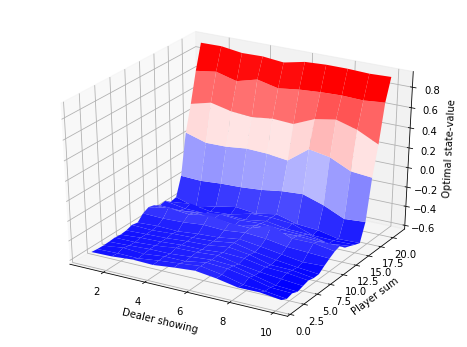

In [273]:
plot_optimal_val_fn(q)

# TD Learning in Easy21
Implement Sarsa($\lambda$) in Easy21. We will implement backward view Sarsa($\lambda$), which uses eligibility traces, one for each state-action pair. We will use the same step-size and exploration schedules as in the previous section. The step size, $\alpha_t = 1/N(s_t, a_t)$, will be calculated using the number of times that the **current** state-action pair has been visited.

For each episode, initialize the eligibility traces to zero:

$$E_0(s, a) = 0$$

Then at each step of the **episode** (perform online updates while the episode is running), decay all eligibility traces, and increment eligibility trace of the current state-action pair by 1:

$$E_t(s, a) = \gamma \lambda E_{t-1}(s, a) + \textbf{1}(S_t = s, A_t = a)$$

Also, at each step of the episode, update $Q(s, a)$ for every state $s$ and action $a$ (**synchronous** update, eligibility traces determine which state-action pairs get updated):

$$\delta_t = R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)$$

$$Q(s, a) \leftarrow Q(s, a) + \alpha \delta_t E_t(s, a)$$

In this case, there is no discount factor ($\gamma = 1$), so $\delta_t$ reduces to

$$\delta_t = R_{t+1} + Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)$$

and the $E_t$ update reduces to

$$E_t(s, a) = \lambda E_{t-1}(s, a) + \textbf{1}(S_t = s, A_t = a)$$

In addition, if $S_{t+1}$ is a terminal state, then we will set $Q(S_{t+1}, A_{t+1}) = 0$ in the action-value function update.

In [333]:
def choose_eps_greedy_action(N_SA, q, state, actions):
    """
    Choose an action from a state according to epsilon-greedy policy.
    
    Inputs:
    - N_SA: counts of state-action pairs visited
    - q: action-value function
    - state: current state
    - actions: list of actions to choose from
    
    Returns:
    - action: the chosen element of actions
    """
    dsum, psum = state
    
    N0 = 100 # initial count to prevent epsilon from changing too much initially
    
    # Follow epsilon-greedy policy
    # calculate probability of choosing random action, for exploration
    eps = N0 / (N0 + np.sum(N_SA[dsum-1, psum-1]))

    # sample random probability to decide on the next action
    sample = np.random.rand()

    action = None
    if sample < eps:
        # Sample action randomly
        action = actions[np.random.randint(len(actions))]
    else:
        # Choose greedy action according to the updated action-value function
        action = actions[np.argmax(q[dsum-1, psum-1])]
    
    return action

In [334]:
def run_sarsa_lambda_episode(N_SA, q, lambd):
    """
    Run an episode (to termination) of Easy21, following epsilon-greedy policy wrt value function.
    Perform online updates using backward view Sarsa(lambda).
    
    Inputs:
    - N_SA: counts of state-action pairs visited
    - q: action-value function, matrix of shape (N, M, A)
        N is number of possible dealer sums
        M is number of possible player sums
        A is number of possible actions
    - lambd: value for lambda, between 0 and 1
    
    Returns:
    - N_SA: updated counts of state-action pairs visited
    - q_new: an updated action-value function, matrix of shape (N, M, A)
    """
    N, M, A = q.shape
    
    q_new = q.copy()
    
    # At start of episode, dealer and player each draw one black card
    dealer_sum, player_sum = np.abs(get_card()), np.abs(get_card())
    state = (dealer_sum, player_sum)
    
    E = np.zeros((N, M, A)) # Initialize eligibility traces

    actions = ['hit', 'stick']
    
    # Initialize action
    action = choose_eps_greedy_action(N_SA, q_new, state, actions)
    
    while state != 'terminal':
        # sample next state and reward from the environment
        # we still want to do a Sarsa update when next_state is 'terminal'
        next_state, reward = step(state, action)
        
        # increment counts and eligibility trace for current (not next) s,a
        dsum, psum = state
        N_SA[dsum-1, psum-1, actions.index(action)] += 1
        E[dsum-1, psum-1, actions.index(action)] += 1
        
        # choose next action and estimate value if next_state is not 'terminal'
        next_action = None
        next_value = None
        if next_state != 'terminal':
            next_dsum, next_psum = next_state

            next_action = choose_eps_greedy_action(N_SA, q_new, next_state, actions)

            # estimate value for next state and action
            next_value = q_new[next_dsum-1, next_psum-1, actions.index(next_action)]
        else:
            # if next_state is 'terminal', then next value is 0
            next_value = 0
        
        # calculate error term using value estimates for next and current s,a pairs
        error = reward + next_value - q_new[dsum-1, psum-1, actions.index(action)]
        
        # calculate step size alpha using count of current (not all) s,a
        alpha = 1 / N_SA[dsum-1, psum-1, actions.index(action)]
        
        # perform synchronous update (all s,a pairs) of the action-value function
        q_new += alpha * error * E
        
        # decay eligibility traces by a factor of lambda
        E *= lambd
        
        state = next_state
        action = next_action
    
    return N_SA, q_new

In [338]:
def sarsa_lambda_control_easy21(lambd, num_episodes=1000):
    """
    Apply Sarsa(lambda) control to Easy21.
    
    Inputs:
    - lambd: value for lambda, between 0 and 1
    - num_episodes: number of episodes to run
    
    Returns:
    - q_list: list of action-value functions after each episode
    """
    N, M, A = 10, 21, 2
    
    N_SA = np.zeros((N, M, A)) # running count of s,a pairs encountered

    # Initialize action-value function
    q = np.zeros((N, M, A))
    
    # Store list of intermediate action-value functions, between episodes
    q_list = []

    for _ in range(num_episodes):
        # Run an episode following epsilon-greedy policy
        N_SA, q = run_sarsa_lambda_episode(N_SA, q, lambd)
        q_list.append(q)
    
    return q_list

## Testing Sarsa($\lambda$) with 1,000 episodes

In [361]:
lambd_values = np.linspace(0, 1, num=11)
q_lists = [sarsa_lambda_control_easy21(lambd) for lambd in lambd_values]

In [365]:
# Calculate mean-squared error for each final action-value function wrt q (determined by MC control)
mse_final = [np.mean((q_list[-1] - q)**2) for q_list in q_lists]

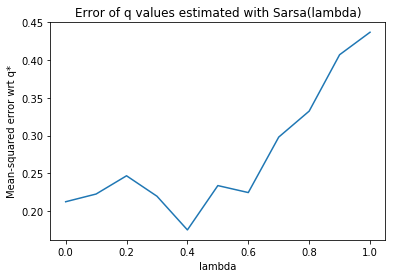

In [366]:
plt.plot(lambd_values, mse_final)
plt.xlabel('lambda')
plt.ylabel('Mean-squared error wrt q*')
plt.title('Error of q values estimated with Sarsa(lambda)')

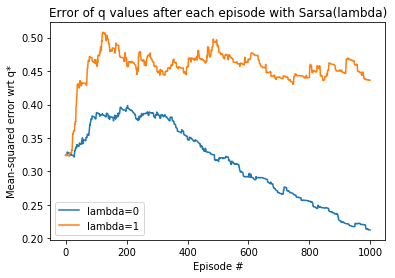

In [364]:
# Calculate mean-squared errors for the action-value functions between episodes for lambda=0
mse_episodic_0 = [np.mean((q_val - q)**2) for q_val in q_lists[0]]

# Calculate mean-squared errors for the action-value functions between episodes for lambda=1
mse_episodic_1 = [np.mean((q_val - q)**2) for q_val in q_lists[-1]]

plt.plot(range(1000), mse_episodic_0, label='lambda=0')
plt.plot(range(1000), mse_episodic_1, label='lambda=1')
plt.legend(loc='best')
plt.xlabel('Episode #')
plt.ylabel('Mean-squared error wrt q*')
plt.title('Error of q values after each episode with Sarsa(lambda)')

## Testing Sarsa($\lambda$) with 100,000 episodes

In [367]:
lambd_values = np.linspace(0, 1, num=11)
q_lists = [sarsa_lambda_control_easy21(lambd, num_episodes=100000) for lambd in lambd_values]

In [368]:
# Calculate mean-squared error for each final action-value function wrt q (determined by MC control)
mse_final = [np.mean((q_list[-1] - q)**2) for q_list in q_lists]

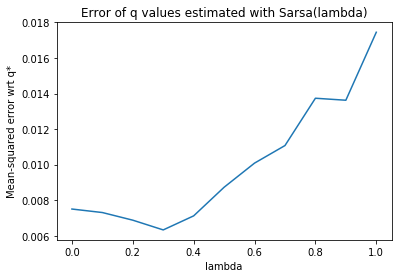

In [369]:
plt.plot(lambd_values, mse_final)
plt.xlabel('lambda')
plt.ylabel('Mean-squared error wrt q*')
plt.title('Error of q values estimated with Sarsa(lambda)')

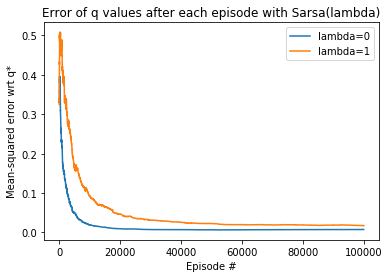

In [370]:
# Calculate mean-squared errors for the action-value functions between episodes for lambda=0
mse_episodic_0 = [np.mean((q_val - q)**2) for q_val in q_lists[0]]

# Calculate mean-squared errors for the action-value functions between episodes for lambda=1
mse_episodic_1 = [np.mean((q_val - q)**2) for q_val in q_lists[-1]]

plt.plot(range(100000), mse_episodic_0, label='lambda=0')
plt.plot(range(100000), mse_episodic_1, label='lambda=1')
plt.legend(loc='best')
plt.xlabel('Episode #')
plt.ylabel('Mean-squared error wrt q*')
plt.title('Error of q values after each episode with Sarsa(lambda)')

# Linear Function Approximation in Easy21
Consider a simple value function approximator using coarse coding. Use a binary feature vector $\phi(s, a)$ with $3*6*2 = 36$ features. Each feature has a value of 1 iff the state-action pair is found in its corresponding region of the state-action space:

$$dealer(s) = \{[1, 4], [4, 7], [7, 10]\}$$
$$player(s) = \{[1, 6], [4, 9], [7, 12], [10, 15], [13, 18], [16, 21]\}$$
$$a = \{hit, stick\}$$

where $dealer(s)$ is the value of the dealer's first card (1-10), and $player(s)$ is the sum of the player's cards (1-21).

Repeat the Sarsa($\lambda$) experiment from the previous section, but using linear value function approximation $Q(s, a) = \phi(s, a)^\top \theta$.

Use a constant exploration of $\epsilon = 0.05$ and a constant step size of 0.01.

In [414]:
def build_feature_vector(state, action):
    """
    Build a binary feature vector from the given state and action
    
    Inputs:
    - state: tuple consisting of dealer's hand (1-10) and player's sum (1-21)
    - action: 'hit' or 'stick'
    
    Returns:
    - features: binary feature vector, shape (3*6*2,)
    """
    dsum, psum = state
    
    actions = ['hit', 'stick']
    a_ind = actions.index(action)
    
    features = np.zeros((3, 6, 2))
    
    dim1 = [np.arange(1, 4+1), np.arange(4, 7+1), np.arange(7, 10+1)]
    dim2 = [np.arange(1, 6+1), np.arange(4, 9+1), np.arange(7, 12+1),
            np.arange(10, 15+1), np.arange(13, 18+1), np.arange(16, 21+1)]
    
    # Get indices for the intervals that contain the state
    in_dim1 = np.nonzero([(dsum in interval) for interval in dim1])[0]
    in_dim2 = np.nonzero([(psum in interval) for interval in dim2])[0]
    
    # Set corresponding features to 1
    for i in in_dim1:
        for j in in_dim2:
            features[i, j, a_ind] = 1
    
    # Flatten the feature vector
    features = features.flatten()
    
    return features

In [424]:
def compute_value_fn_from_lfa_parameters(theta):
    """
    Compute the action-value function from parameters of a linear function approximator.
    Basically, compute the action-value for every possible state-action pair.
    
    Inputs:
    - theta: parameters of the linear function approximator, shape (3*6*2,)
    
    Returns:
    - q: action-value function, shape (N, M, A)
        N is number of possible dealer sums
        M is number of possible player sums
        A is number of possible actions
    """
    N, M, A = 10, 21, 2
    
    actions = ['hit', 'stick']
    
    q = np.zeros((N, M, A))
    
    # Compute the action value for every state-action pair
    for n in range(N):
        for m in range(M):
            for a in range(A):
                features = build_feature_vector((n+1, m+1), actions[a])
                q[n, m, a] = np.dot(features, theta)
    
    return q

In [419]:
def choose_eps_greedy_action_const_eps(eps, theta, state, actions):
    """
    Choose an action from a state according to epsilon-greedy policy.
    
    Inputs:
    - eps: probability of choosing an action at random
    - theta: parameters for linear function approximator of action-value function
    - state: current state
    - actions: list of actions to choose from
    
    Returns:
    - action: the chosen element of actions
    """
    # Calculate possible feature vectors from this state
    possible_features = [build_feature_vector(state, action) for action in actions]

    # sample random probability to decide on the next action
    sample = np.random.rand()

    action = None
    if sample < eps:
        # Sample action randomly
        action = actions[np.random.randint(len(actions))]
    else:
        # Choose greedy action according to action-values
        possible_values = [np.dot(features, theta) for features in possible_features]
        action = actions[np.argmax(possible_values)]
    
    return action

In [433]:
def run_sarsa_lambda_episode_with_lfa(theta, lambd):
    """
    Run an episode (to termination) of Easy21, following epsilon-greedy policy
    wrt value function, which is estimated with a linear function approximator
    parameterized by theta.
    Perform online updates using backward view Sarsa(lambda).
    
    Inputs:
    - theta: parameters of linear function approximator for action-value function, shape (3*6*2,)
    - lambd: value for lambda, between 0 and 1
    
    Returns:
    - theta_new: updated parameters, shape (3*6*2,)
    - q: resulting action-value function, matrix of shape (N, M, A)
        N is number of possible dealer sums
        M is number of possible player sums
        A is number of possible actions
        determined by using theta to calculate the action-value of every state-action pair
    """
    theta_new = theta.copy()
    
    eps = 0.05 # constant probability for epsilon-greedy policy
    alpha = 0.01 # constant step size
    
    # At start of episode, dealer and player each draw one black card
    dealer_sum, player_sum = np.abs(get_card()), np.abs(get_card())
    state = (dealer_sum, player_sum)
    
    E = np.zeros(3*6*2) # Initialize eligibility traces (tracks occurrences of features)

    actions = ['hit', 'stick']
    
    # Initialize action
    action = choose_eps_greedy_action_const_eps(eps, theta_new, state, actions)
    
    while state != 'terminal':
        # sample next state and reward from the environment
        # we still want to do a Sarsa update when next_state is 'terminal'
        next_state, reward = step(state, action)
        
        # increment eligibility traces for current (not next) s,a
        features = build_feature_vector(state, action)
        E += features
        
        # choose next action and estimate value if next_state is not 'terminal'
        next_action = None
        next_value = None
        if next_state != 'terminal':
            next_action = choose_eps_greedy_action_const_eps(eps, theta_new, next_state, actions)

            # estimate value for next state and action
            next_features = build_feature_vector(next_state, next_action)
            next_value = np.dot(next_features, theta)
        else:
            # if next_state is 'terminal', then next value is 0
            next_value = 0
        
        # calculate error term using value estimates for next and current s,a pairs
        error = reward + next_value - np.dot(features, theta)
        
        # update the parameters
        theta_new += alpha * error * E
        
        # decay eligibility traces by a factor of lambda
        E *= lambd
        
        # compute action-value function from parameters theta
        # this uses nested loops and greatly slows down the algorithm - is there another way?
        q = compute_value_fn_from_lfa_parameters(theta)
        
        state = next_state
        action = next_action
    
    return theta_new, q

In [434]:
def sarsa_lambda_control_with_lfa_easy21(lambd, num_episodes=1000):
    """
    Apply Sarsa(lambda) control to Easy21, using a linear function approximator
    to estimate the action-value function.
    
    Inputs:
    - lambd: value for lambda, between 0 and 1
    - num_episodes: number of episodes to run
    
    Returns:
    - q_list: list of action-value functions after each episode
    """
    # Initialize parameters for linear function approximation
    initial_weights = 1e-6
    theta = np.random.randn(3*6*2) * initial_weights
    
    # Store list of intermediate action-value functions, between episodes
    q_list = []

    for i in range(num_episodes):
        # Run an episode following epsilon-greedy policy
        theta, q = run_sarsa_lambda_episode_with_lfa(theta, lambd)
        q_list.append(q)
    
    return q_list

## Testing Sarsa($\lambda$) with Linear Function Approximation with 1,000 episodes

In [437]:
lambd_values = np.linspace(0, 1, num=11)
q_lists_lfa = []

for lambd in lambd_values:
    q_lists_lfa.append(sarsa_lambda_control_with_lfa_easy21(lambd))
    print('lambda=%s finished' % lambd)

lambda=0.0 finished
lambda=0.1 finished
lambda=0.2 finished
lambda=0.30000000000000004 finished
lambda=0.4 finished
lambda=0.5 finished
lambda=0.6000000000000001 finished
lambda=0.7000000000000001 finished
lambda=0.8 finished
lambda=0.9 finished
lambda=1.0 finished


In [438]:
# Calculate mean-squared error for each final action-value function wrt q (determined by MC control)
mse_final_lfa = [np.mean((q_list[-1] - q)**2) for q_list in q_lists_lfa]

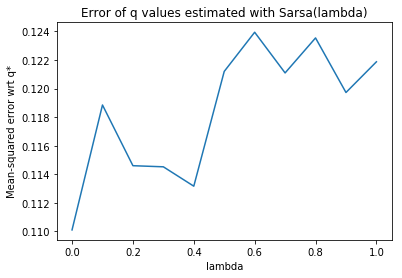

In [439]:
plt.plot(lambd_values, mse_final_lfa)
plt.xlabel('lambda')
plt.ylabel('Mean-squared error wrt q*')
plt.title('Error of q values estimated with Sarsa(lambda)')

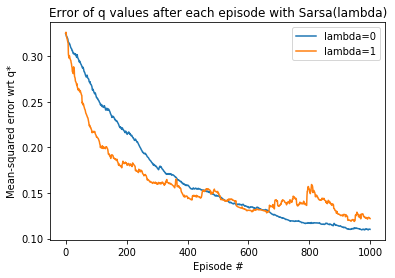

In [440]:
# Calculate mean-squared errors for the action-value functions between episodes for lambda=0
mse_episodic_0_lfa = [np.mean((q_val - q)**2) for q_val in q_lists_lfa[0]]

# Calculate mean-squared errors for the action-value functions between episodes for lambda=1
mse_episodic_1_lfa = [np.mean((q_val - q)**2) for q_val in q_lists_lfa[-1]]

plt.plot(range(1000), mse_episodic_0_lfa, label='lambda=0')
plt.plot(range(1000), mse_episodic_1_lfa, label='lambda=1')
plt.legend(loc='best')
plt.xlabel('Episode #')
plt.ylabel('Mean-squared error wrt q*')
plt.title('Error of q values after each episode with Sarsa(lambda)')